In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.initializers import Constant
import time

In [2]:
data = pd.read_csv('/content/movie.csv')

In [3]:
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [4]:
data['label'].value_counts(normalize=True)

0    0.500475
1    0.499525
Name: label, dtype: float64

In [5]:
nltk.download('stopwords')
# We filter out the english language stopwrds

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
remove_chars = "@S+|https?:S+|http?:S|[^A-Za-z0-9]+"

In [7]:
def tokenize_text(text):
  # Text passed to the regex equatio
  text = re.sub(remove_chars, ' ', str(text).lower()).strip()
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stop_words:
        tokens.append(token)
  return " ".join(tokens)

In [8]:
data['tokenized_text'] = data['text'].apply(lambda x: tokenize_text(x))

In [9]:
data.head()

,text,label,tokenized_text
0,I grew up (b. 1965) watching and loving the Th...,0,grew b 1965 watching loving thunderbirds mates...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chips expectatio...
2,Why do people who do not know what a particula...,0,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movies bor...
4,Im a die hard Dads Army fan and nothing will e...,1,im die hard dads army fan nothing ever change ...


In [10]:
train,test = train_test_split(data, test_size=0.25, random_state=42)

In [11]:
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [12]:
test.head()

,text,label,tokenized_text
0,The central theme in this movie seems to be co...,0,central theme movie seems confusion relationsh...
1,"An excellent example of ""cowboy noir"", as it's...",1,excellent example cowboy noir called unemploye...
2,The ending made my heart jump up into my throa...,0,ending made heart jump throat proceeded leave ...
3,Only the chosen ones will appreciate the quali...,1,chosen ones appreciate quality story character...
4,"This is a really funny film, especially the se...",1,really funny film especially second third four...


In [13]:
train.shape, test.shape

((30000, 3), (10000, 3))

In [14]:
# tfidf = TfidfVectorizer(max_features=1000)
# tfidf.fit(train['tokenized_text'])

In [15]:
from keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=1000, output_sequence_length=100)
vectorizer.adapt(train['tokenized_text'])
voc = vectorizer.get_vocabulary()

In [16]:
len(voc)

1000

In [17]:
x_train = vectorizer(np.array([[s] for s in train['tokenized_text']])).numpy()
x_test  = vectorizer(np.array([[s] for s in test['tokenized_text']])).numpy()

In [18]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(train['label'].tolist()).reshape(-1,1))
y_train = enc.transform(np.array(train['label'].tolist()).reshape(-1,1)).toarray()
y_test = enc.transform(np.array(test['label'].tolist()).reshape(-1,1)).toarray()

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((30000, 100), (30000, 2), (10000, 100), (10000, 2))

In [20]:
def model(input_dim,model_type,num_classes):
  model = Sequential()
  model.add(Embedding(input_dim = input_dim , output_dim = 100))
  if model_type == 'vanilla':
    model.add(SimpleRNN(32))
  elif model_type == 'GRU':
    model.add(GRU(32))
  else:
    model.add(LSTM(32))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [21]:
len(voc)

1000

In [22]:
rnn = model(len(voc),'vanilla',2)

In [23]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 105378 (411.63 KB)
Trainable params: 105378 (411.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
start_time = time.time()
rnn = model(len(voc),'vanilla',2)
rnn_fitted = rnn.fit(x_train, y_train, epochs=10, validation_split=0.2,batch_size=256)
print('time taken to train the model:', time.time()-start_time)

Epoch 1/10
94/94 [==============================] - 8s 68ms/step - loss: 0.6818 - accuracy: 0.5499 - val_loss: 0.5994 - val_accuracy: 0.7175
Epoch 2/10
94/94 [==============================] - 7s 75ms/step - loss: 0.4650 - accuracy: 0.7960 - val_loss: 0.4117 - val_accuracy: 0.8220
Epoch 3/10
94/94 [==============================] - 6s 63ms/step - loss: 0.3728 - accuracy: 0.8424 - val_loss: 0.4136 - val_accuracy: 0.8128
Epoch 4/10
94/94 [==============================] - 7s 75ms/step - loss: 0.3432 - accuracy: 0.8573 - val_loss: 0.4081 - val_accuracy: 0.8187
Epoch 5/10
94/94 [==============================] - 6s 59ms/step - loss: 0.3230 - accuracy: 0.8643 - val_loss: 0.4154 - val_accuracy: 0.8198
Epoch 6/10
94/94 [==============================] - 7s 76ms/step - loss: 0.2934 - accuracy: 0.8792 - val_loss: 0.4541 - val_accuracy: 0.8267
Epoch 7/10
94/94 [==============================] - 7s 74ms/step - loss: 0.2597 - accuracy: 0.8979 - val_loss: 0.4649 - val_accuracy: 0.8185
Epoch 8/10
94

In [25]:
gru = model(len(voc),'GRU',2)
gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         100000    
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 113986 (445.26 KB)
Trainable params: 113986 (445.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
start_time = time.time()
gru = model(len(voc),'GRU',2)
gru_fitted =gru.fit(x_train, y_train, epochs=10, validation_split=0.2)
print('time taken to train the model:', time.time()-start_time)

Epoch 1/10
750/750 [==============================] - 33s 41ms/step - loss: 0.6727 - accuracy: 0.5598 - val_loss: 0.6649 - val_accuracy: 0.5727
Epoch 2/10
750/750 [==============================] - 30s 40ms/step - loss: 0.5052 - accuracy: 0.7432 - val_loss: 0.4064 - val_accuracy: 0.8178
Epoch 3/10
750/750 [==============================] - 30s 41ms/step - loss: 0.3492 - accuracy: 0.8461 - val_loss: 0.3739 - val_accuracy: 0.8338
Epoch 4/10
750/750 [==============================] - 30s 41ms/step - loss: 0.3172 - accuracy: 0.8655 - val_loss: 0.3931 - val_accuracy: 0.8250
Epoch 5/10
750/750 [==============================] - 31s 41ms/step - loss: 0.2968 - accuracy: 0.8747 - val_loss: 0.3864 - val_accuracy: 0.8288
Epoch 6/10
750/750 [==============================] - 30s 39ms/step - loss: 0.2794 - accuracy: 0.8834 - val_loss: 0.3923 - val_accuracy: 0.8255
Epoch 7/10
750/750 [==============================] - 31s 41ms/step - loss: 0.2648 - accuracy: 0.8915 - val_loss: 0.4020 - val_accuracy:

In [27]:
lstm = model(len(voc),'lstm',2)
lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         100000    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 118146 (461.51 KB)
Trainable params: 118146 (461.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
start_time = time.time()
lstm = model(len(voc),'lstm',2)
lstm_fitted=lstm.fit(x_train, y_train, epochs=10, validation_split=0.2)
print('time taken to train the model:', time.time()-start_time)

Epoch 1/10
750/750 [==============================] - 37s 47ms/step - loss: 0.5249 - accuracy: 0.7195 - val_loss: 0.4032 - val_accuracy: 0.8270
Epoch 2/10
750/750 [==============================] - 31s 42ms/step - loss: 0.3809 - accuracy: 0.8350 - val_loss: 0.4024 - val_accuracy: 0.8307
Epoch 3/10
750/750 [==============================] - 32s 43ms/step - loss: 0.3537 - accuracy: 0.8470 - val_loss: 0.3865 - val_accuracy: 0.8243
Epoch 4/10
750/750 [==============================] - 31s 41ms/step - loss: 0.3362 - accuracy: 0.8543 - val_loss: 0.3835 - val_accuracy: 0.8342
Epoch 5/10
750/750 [==============================] - 32s 42ms/step - loss: 0.3183 - accuracy: 0.8634 - val_loss: 0.4051 - val_accuracy: 0.8280
Epoch 6/10
750/750 [==============================] - 33s 44ms/step - loss: 0.3023 - accuracy: 0.8707 - val_loss: 0.4036 - val_accuracy: 0.8248
Epoch 7/10
750/750 [==============================] - 39s 52ms/step - loss: 0.2830 - accuracy: 0.8808 - val_loss: 0.4176 - val_accuracy:

In [26]:
def performance(model, x, y):

  loss,accuracy = model.evaluate(x,y)
  print(loss)
  print(accuracy)
  y_pred = model.predict(x)
  predicted_classes = np.argmax(y_pred, axis=1)
  true_classes = np.argmax(y, axis=1)

  conf_matrix = confusion_matrix(true_classes, predicted_classes)

  plt.figure()
  sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False)
  plt.xlabel("True Label")
  plt.ylabel("Predicted Label")

Confusion matrix of RNN model:
938/938 [==============================] - 9s 10ms/step - loss: 0.2435 - accuracy: 0.9355
0.2435411959886551
0.9354666471481323
938/938 [==============================] - 8s 8ms/step


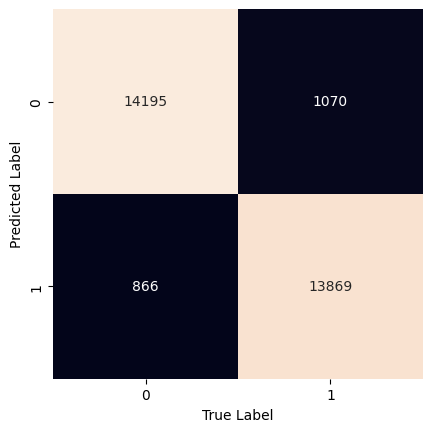

In [27]:
print('Confusion matrix of RNN model:')
performance(rnn,x_train,y_train)

Confusion matrix of RNN model:
313/313 [==============================] - 3s 11ms/step - loss: 0.9698 - accuracy: 0.7459
0.9697715044021606
0.7458999752998352
313/313 [==============================] - 2s 8ms/step


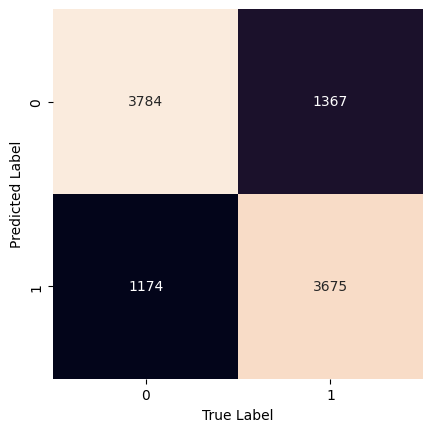

In [28]:
print('Confusion matrix of RNN model:')
performance(rnn,x_test,y_test)

Confusion matrix of LSTM model:
938/938 [==============================] - 13s 14ms/step - loss: 0.2620 - accuracy: 0.8963
0.2620275616645813
0.8963333368301392
938/938 [==============================] - 14s 14ms/step


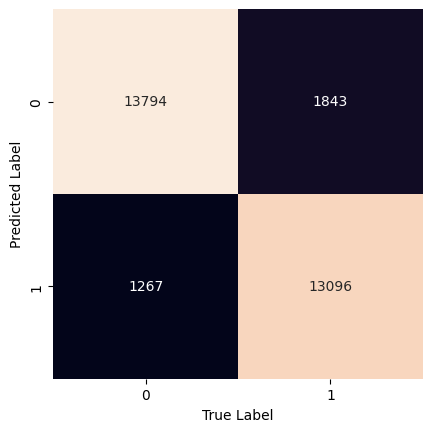

In [29]:
print('Confusion matrix of LSTM model:')
performance(lstm,x_train,y_train)

Confusion matrix of LSTM model:
313/313 [==============================] - 4s 13ms/step - loss: 0.4733 - accuracy: 0.8077
0.47330960631370544
0.807699978351593
313/313 [==============================] - 4s 13ms/step


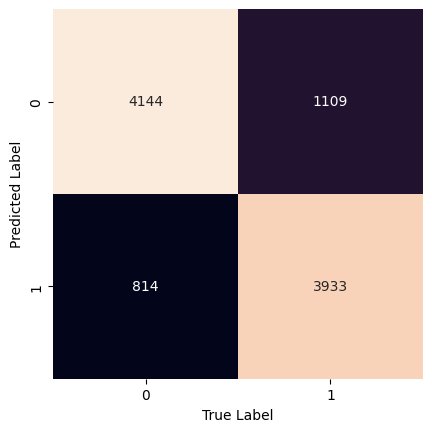

In [30]:
print('Confusion matrix of LSTM model:')
performance(lstm,x_test,y_test)

Confusion matrix of GRU model:
938/938 [==============================] - 12s 13ms/step - loss: 0.2495 - accuracy: 0.9046
0.2494727522134781
0.9046333432197571
938/938 [==============================] - 13s 13ms/step


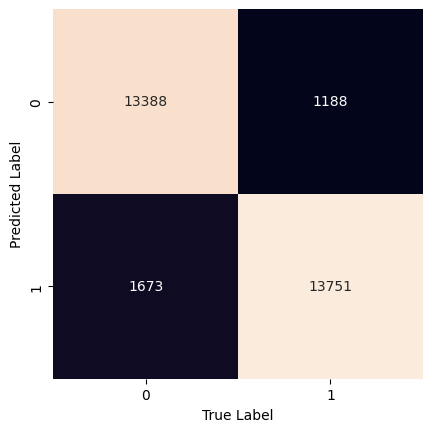

In [31]:
print('Confusion matrix of GRU model:')
performance(gru,x_train,y_train)

Confusion matrix of GRU model:
313/313 [==============================] - 4s 12ms/step - loss: 0.4655 - accuracy: 0.8118
0.465484619140625
0.8118000030517578
313/313 [==============================] - 4s 14ms/step


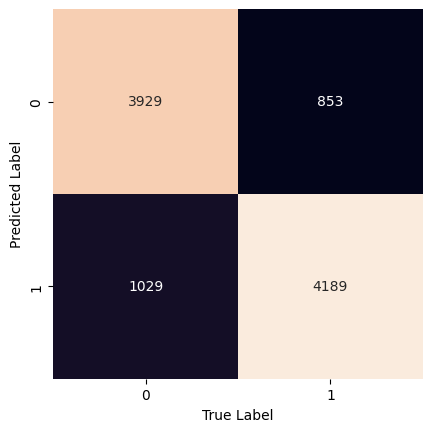

In [32]:
print('Confusion matrix of GRU model:')
performance(gru,x_test,y_test)

In [33]:
test['no_of_tokens'] = test['tokenized_text'].apply(lambda x : len(x.split(' ',-1)))

In [34]:
test.head()

,text,label,tokenized_text,no_of_tokens
0,The central theme in this movie seems to be co...,0,central theme movie seems confusion relationsh...,148
1,"An excellent example of ""cowboy noir"", as it's...",1,excellent example cowboy noir called unemploye...,241
2,The ending made my heart jump up into my throa...,0,ending made heart jump throat proceeded leave ...,29
3,Only the chosen ones will appreciate the quali...,1,chosen ones appreciate quality story character...,67
4,"This is a really funny film, especially the se...",1,really funny film especially second third four...,63


In [35]:
sorted_test = test.sort_values('no_of_tokens')
n = len(test)
short_indices = sorted_test.index[0:int(0.33*n)]
short_x_test = x_test[short_indices]
short_y_test = y_test[short_indices]

medium_indices = sorted_test.index[int(0.33*n):int(0.67*n)]
medium_x_test = x_test[medium_indices]
medium_y_test = y_test[medium_indices]

long_indices = sorted_test.index[int(0.67*n):-1]
long_x_test = x_test[long_indices]
long_y_test = y_test[long_indices]

104/104 [==============================] - 1s 8ms/step - loss: 0.6324 - accuracy: 0.8212
0.6324098706245422
0.821212112903595
107/107 [==============================] - 1s 8ms/step - loss: 0.9169 - accuracy: 0.7518
0.9169014096260071
0.751764714717865
104/104 [==============================] - 1s 8ms/step - loss: 1.3620 - accuracy: 0.6644
1.3620173931121826
0.6644437909126282
104/104 [==============================] - 1s 12ms/step - loss: 0.3587 - accuracy: 0.8503
0.3586712181568146
0.850303053855896
107/107 [==============================] - 1s 12ms/step - loss: 0.4216 - accuracy: 0.8291
0.42159804701805115
0.8291176557540894
104/104 [==============================] - 1s 13ms/step - loss: 0.6414 - accuracy: 0.7430
0.6414075493812561
0.7429524064064026
104/104 [==============================] - 1s 11ms/step - loss: 0.3308 - accuracy: 0.8633
0.3308359682559967
0.8633333444595337
107/107 [==============================] - 1s 12ms/step - loss: 0.4136 - accuracy: 0.8291
0.4135618209838867


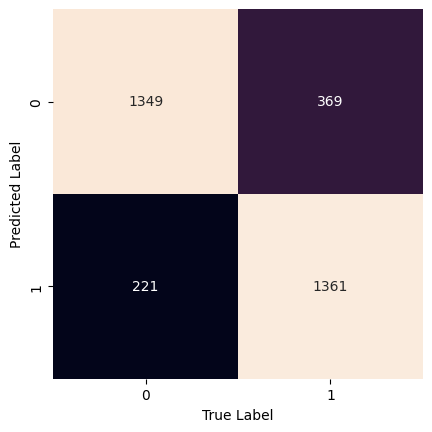

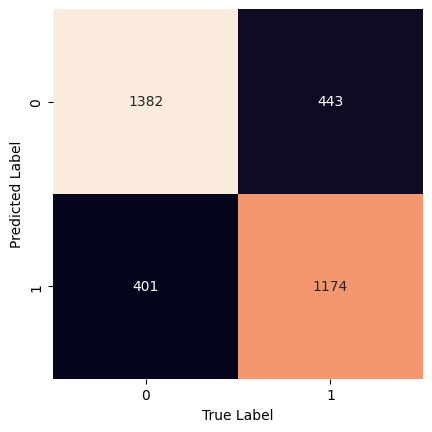

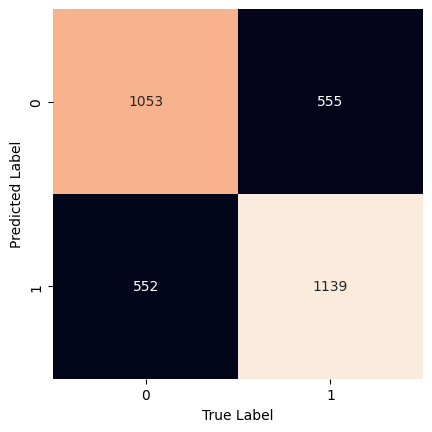

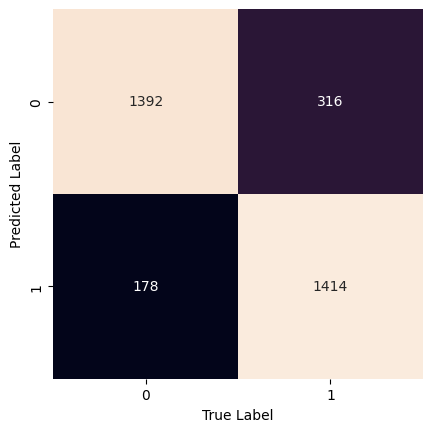

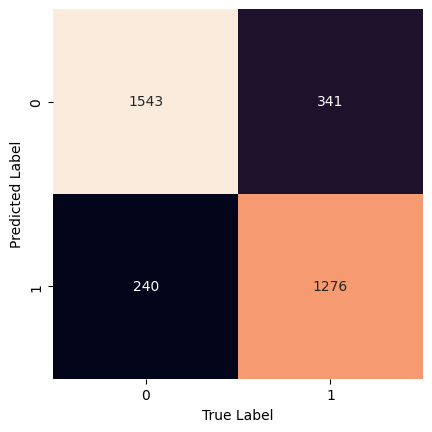

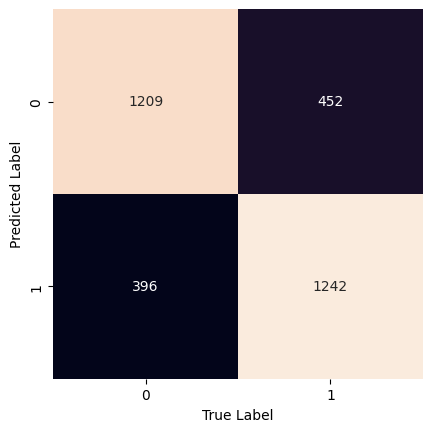

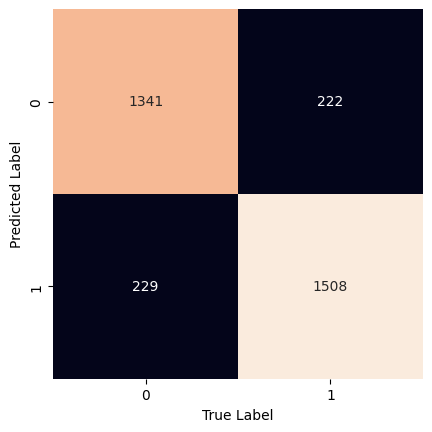

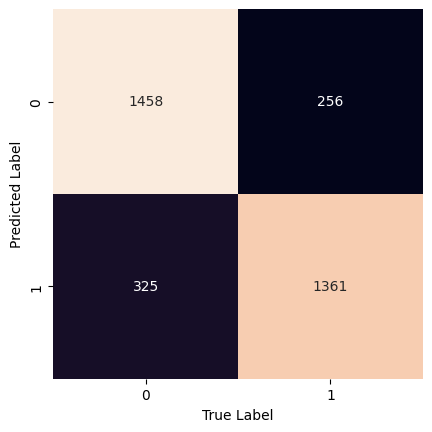

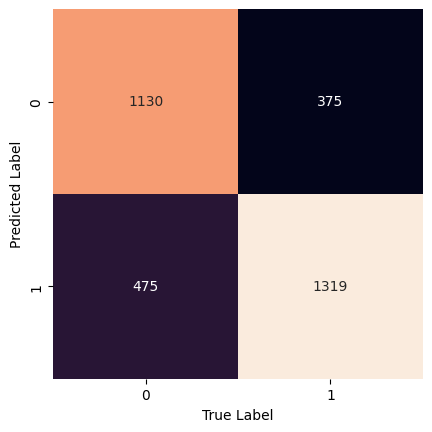

In [37]:
for model in ('rnn','lstm','gru'):
  for data in ('short','medium','long'):
    if data == 'short':
      x = short_x_test
      y = short_y_test
    elif data == 'medium':
      x = medium_x_test
      y = medium_y_test
    else:
      x = long_x_test
      y = long_y_test

    if model == 'rnn':
      trained_model = rnn
    elif model == 'lstm':
      trained_model = lstm
    else:
      trained_model = gru

    performance(trained_model, x,y)